# An Introduction to Data Analysis of Single Cell RNASeq: An illustration with 10X Chromium Data

## Getting Started

We will run through a quick hands-on demo of the workflow for a single cell RNAseq dataset using the __10X genomics Chromium__ platform.

For this tutorial, we will be using three R packages __`Seurat`__, __`Scater`__ and __`Scran`__. As we have discussed, methods and package development in this ares is highly dynamic and therefore we expect things to change very soon. However, there are a couple of standards that have been implemented:

1. The development of the _`SingleCellExperiment`_ data structure in __Bioconductor__, which will eventually be the _de-facto_ standard for future Bioconductor pacakges

2. The general workflow for a given set of data


Let us now load the required packages

In [1]:
suppressPackageStartupMessages(library(Seurat))

In [2]:
library(IRdisplay)

In [3]:
suppressPackageStartupMessages(library(scran))

In [4]:
suppressPackageStartupMessages(library(scater))

<hr class="style0"> </hr>

This workshop is based on the __[Seurat-Guided Clustering Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html)__ which uses aa dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. We have already downloaded this datase in prepartion. 

First, we read in the data using a __`Seurat`__ function

In [5]:
pbmc.data <- Read10X(data.dir = "~/workshop_materials/scrna_workshop_data/filtered_gene_bc_matrices/hg19/")

<div class="alert alert-block alert-info">
 user  system elapsed <br>
  8.404   0.100   8.504 
</div>

<hr class="style0"> </hr>

Initialize the Seurat object with the raw (non-normalized data).  

In [6]:
pbmc <- CreateSeuratObject(raw.data = pbmc.data, min.cells = 0, min.genes = 0, project = "10X_PBMC")


<div class="time">
   user  system elapsed <br>
  3.040   0.016   3.057 
</div>

In [7]:
str(pbmc)

Formal class 'seurat' [package "Seurat"] with 20 slots
  ..@ raw.data    :Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:2286884] 70 166 178 326 363 410 412 492 494 495 ...
  .. .. ..@ j       : int [1:2286884] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..@ Dim     : int [1:2] 32738 2700
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:32738] "MIR1302-10" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .. .. .. ..$ : chr [1:2700] "AAACATACAACCAC" "AAACATTGAGCTAC" "AAACATTGATCAGC" "AAACCGTGCTTCCG" ...
  .. .. ..@ x       : num [1:2286884] 1 1 2 1 1 1 1 41 1 1 ...
  .. .. ..@ factors : list()
  ..@ data        :Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:2286884] 70 166 178 326 363 410 412 492 494 495 ...
  .. .. ..@ j       : int [1:2286884] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..@ Dim     : int [1:2] 32738 2700
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:32738] "MIR1302-10" "FAM138A" "OR4F5" "RP11-34P13.7" ...
  .

<div class="alert alert-block alert-info">
   
 <i>From Seurat tutorial</i>
 
 Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes. The number of genes and UMIs (nGene and nUMI) are automatically calculated for every object by Seurat.  For non-UMI data, nUMI represents the sum of the non-normalized values within a cell We calculate the percentage of  mitochondrial genes here and store it in percent.mito using AddMetaData. We use object@raw.data since this represents non-transformed and non-log-normalized counts. The % of UMI mapping to MT-genes is a common scRNA-seq QC metric.<br>
    
   <br> <code>mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)</code>
<br>

    <code>percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ])/Matrix::colSums(pbmc@raw.data)</code>
</div>


We create a gene map table from the 10X data as Seurat by default only uses the gene names instead of the Ensembl ID and this can lead to difficulty in assigning cell cycle phase later on.


In [8]:
gene_map <- read.table("~/workshop_materials/scrna_workshop_data/filtered_gene_bc_matrices/hg19/genes.tsv",
                       header=F)
names(gene_map)<-c("Ens_ID","name")
head(gene_map, n=2)

Ens_ID,name
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A


Lets take a peek at the Raw Data

In [9]:
as.matrix(tail(pbmc@raw.data, n=2))

,AAACATACAACCAC,AAACATTGAGCTAC,AAACATTGATCAGC,AAACCGTGCTTCCG,AAACCGTGTATGCG,AAACGCACTGGTAC,AAACGCTGACCAGT,AAACGCTGGTTCTT,AAACGCTGTAGCCA,AAACGCTGTTTCTG,⋯,TTTCAGTGTCACGA,TTTCAGTGTCTATC,TTTCAGTGTGCAGT,TTTCCAGAGGTGAG,TTTCGAACACCTGA,TTTCGAACTCTCAT,TTTCTACTGAGGCA,TTTCTACTTCCTCG,TTTGCATGAGAGGC,TTTGCATGCCTCAC
AC002321.2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AC002321.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


<hr class="style0">
Lets create an `SingleCellExperiment` object from the `seurat` object so we can use the __`SCATER`__ and __`SCRAN`__ packages

In [10]:
sce <- SingleCellExperiment(list(counts=as.matrix(pbmc@raw.data)))

In [11]:
str(sce)

Formal class 'SingleCellExperiment' [package "SingleCellExperiment"] with 10 slots
  ..@ int_elementMetadata:Formal class 'DataFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 32738
  .. .. ..@ listData       : Named list()
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ int_colData        :Formal class 'DataFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 2700
  .. .. ..@ listData       : Named list()
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ int_metadata       :List of 1
  .. ..$ version:Classes 'package_version', 'numeric_version'  hidden list of 1
  .. .. ..$ : int [1:3] 1 0 0
  ..@ reducedDims        :Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  .. .. ..@ listData       : list()
  .. .. ..@ elementType    : 


Then we can add an simple CPM transformation to the original matrix count matrix and store it

In [12]:
exprs(sce) <- log2(calculateCPM(sce, use.size.factors = FALSE) + 1)  #SCATER

In [13]:
dim(exprs(sce))

[1] 32738  2700

In [14]:
head(rowSums(exprs(sce)), n=2)

MIR1302-10    FAM138A 
         0          0

In [15]:
head(colnames(sce), n=2)

[1] "AAACATACAACCAC" "AAACATTGAGCTAC"

These packages also let us use spike-in data if thats available, which is not the case for droplet based methods, but works well in other technbologies. However, we can use the functionality to mark other sets of genes, in this case the gene expression annotated to be of mitochondrial origin.

In [16]:
isSpike(sce, "MT") <- grepl("^MT-", rownames(sce)) #SCATER

<div class="alert alert-block alert-warning">

One advantage of the <code>SCATER</code> package is that there is an automated procedure for calculating a large set of QC metics automatically. 

In the case of Seurat you would have to manually calculate each metric as show below for the calculation of the mitochondirial percent UMI's <i>(Not run)</i>:<br><br>

<code># The number of genes and UMIs (nGene and nUMI) are automatically calculated for every object by Seurat.
# For non-UMI data, nUMI represents the sum of the non-normalized values within a cell
# We calculate the percentage of mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and non-log-normalized counts
# The % of UMI mapping to MT-genes is a common scRNA-seq QC metric.<br>

mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)
percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ]) / Matrix::colSums(pbmc@raw.data)<br>


# AddMetaData adds columns to object@meta.data, and is a great place to stash QC stats
pbmc <- AddMetaData(object = pbmc, metadata = percent.mito, col.name = "percent.mito")<br></code>

</div>

In [17]:
sce <- calculateQCMetrics(sce,feature_controls = list(MT = isSpike(sce, "MT") )) #SCATER

<div class="time">
  user  system elapsed <br>
  9.988   0.268  10.257 
  </div>  


Lets see what metrics have been derived for:
 
 * The cells 

In [18]:
cbind(names(colData(sce)))

total_features
log10_total_features
total_counts
log10_total_counts
pct_counts_top_50_features
pct_counts_top_100_features
pct_counts_top_200_features
pct_counts_top_500_features
total_features_endogenous
log10_total_features_endogenous
total_counts_endogenous



<hr style="height:3px;border:none;color:#333;background-color:#333;" />

 * The genes

In [19]:
cbind(names(rowData(sce)))

is_feature_control
is_feature_control_MT
mean_counts
log10_mean_counts
rank_counts
n_cells_counts
pct_dropout_counts
total_counts
log10_total_counts


<hr class="style0">

Finally, let us add some cell cycle information from the __`Scran`__ package. This package has default training datasets for assingment of cell cycle states to data for Human and Mouse.


But, first we use our `gene_map` dataset to map the gene names to Ensembl Gene IDs as the training sets are based on Ensembl Gene IDs

In [20]:
ens_pos <- match(rownames(counts(sce)), gene_map$name)
rownames(sce@assays[['counts']]) <- gene_map$Ens_ID[ens_pos]

<div class="alert alert-info">

<h5> **INFO!!**  Double check that the assignments are correct </h5>

</div>

In [21]:
cbind(rownames(counts(sce))[1:6],as.character(gene_map$name[1:6]))

MIR1302-10,MIR1302-10
FAM138A,FAM138A
OR4F5,OR4F5
RP11-34P13.7,RP11-34P13.7
RP11-34P13.8,RP11-34P13.8
AL627309.1,AL627309.1


<div class="alert alert-info">

</div>



Read in the pre-computed cell-cycle data from the  __`scran`__  package

In [22]:
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))

<div class="alert alert-block alert-info">
<i><b>INFO</b></i>: For using the precomputed mouse sets we do: <br><br>


<code>mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))</code>
    
</div>

   <div class="alert alert-block alert-warning">
   
   <b>NOTE</b>: We will be using the code below to assign the cell-cycle phases for each cell using the <b>cyclone</b> algorithm presented in <i>[Scialdone, A. et al](http://linkinghub.elsevier.com/retrieve/pii/S1046202315300098)</i>.
   
   We do not run this as it takes > 1 hour to run, instead these values are precomputed and stored as an R object that we will load.
   
<br>

<code>assigned <- cyclone(sce@assays[['counts']], pairs=hg.pairs)
save(assigned,file="~/scrna_workshop/scrna_workshop_data/pbmc_3k_cyclone_assigned.rda")</code>
   
   </div>

<div class="time">
    user   system  elapsed <br>
4734.160    0.000 4734.586 
</div>

In [23]:
load(file="~/workshop_materials/scrna_workshop_data/pbmc_3k_cyclone_assigned.rda")

Let us explore the assigned data set

In [24]:
head(assigned$phases)

[1] "G1" "G1" "G1" "G1" "S"  "G1"

In [25]:
head(assigned$scores)

G1,S,G2M
0.989,0.263,0.002
0.541,0.659,0.045
0.998,0.423,0.000
0.947,0.088,0.079
0.428,0.292,0.202
0.965,0.092,0.049


In [26]:
table(assigned$phases)


  G1  G2M    S 
2541   63   96 

We will now add the scores and the phases to the _colData_ component of our _SingleCellExpressionSet_ and save the final raw data object we have created

In [27]:
newcoldat <- colData(sce)

In [28]:
newcoldat$cycle_phases <- assigned$phases

In [29]:
newcoldat<- cbind(newcoldat,assigned$scores)

In [30]:
colData(sce) <- newcoldat


<div class="extra">
 We will save the raw data object in case we want to work with it using a different filtering strategy
    <br>
    <br>
    
    
    
    <code>save(sce,file="~/scrna_workshop/scrna_workshop_data/pbmc_3k_sce_raw.rda")</code>
    
</div>
    

In [31]:
load(file="~/workshop_materials/scrna_workshop_data/pbmc_3k_sce_raw.rda")

# QC and Filtering

We are now ready to work with our dataset to do some filtering and QC. 

As a first step, let us first remove genes with no expression

In [32]:
keep_feature <- rowSums(counts(sce) > 0 ) > 0
table(keep_feature)

keep_feature
FALSE  TRUE 
16104 16634 

As we see above approximately 50% of the genes have zero counts across all cells. This could be either due to the sensitivity of the experimental method, sequencing depth or that these genes are not expressed.
    
We will go ahead and proceed to drop these from our dataset

In [33]:
sce.filt <- sce[keep_feature,]

In [34]:
dim(sce.filt)

[1] 16634  2700

## QC on Cells

One measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High proportions are indicative of poor-quality cells (Ilicic et al., 2016; Islam et al., 2014), possibly because of increased apoptosis and/or loss of cytoplasmic RNA from lysed cells. Similar reasoning applies to the proportion of reads mapped to spike-in transcripts. The quantity of spike-in RNA added to each cell should be constant, which means that the proportion should increase upon loss of endogenous RNA in low-quality cells. The distributions of mitochondrial  proportions across all cells are shown below

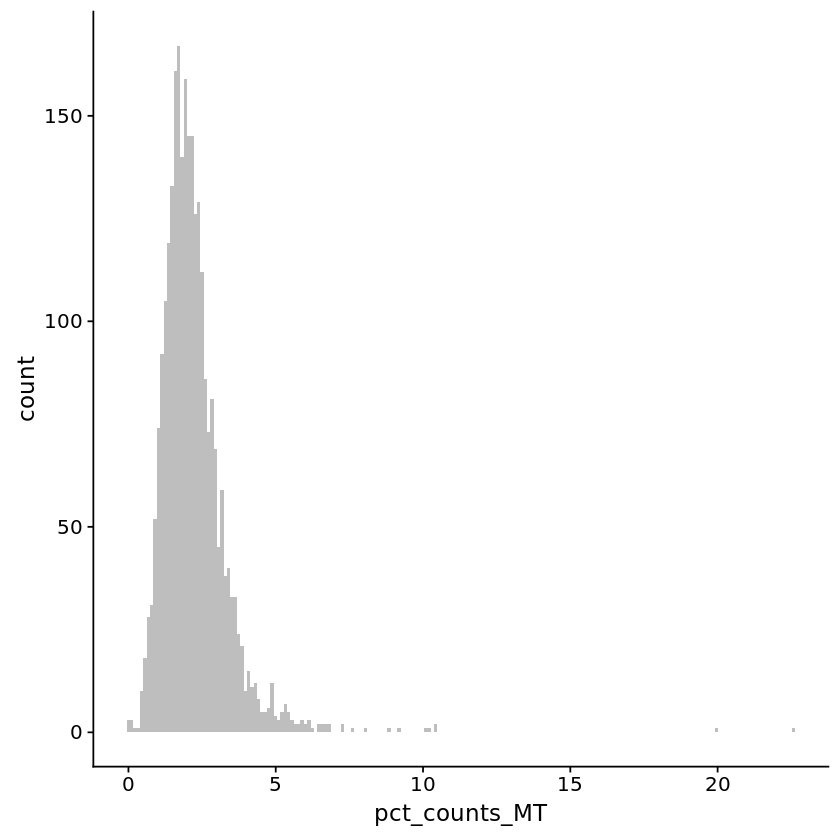

In [35]:
g1 = ggplot(as.data.frame(colData(sce.filt))) 
g1 = g1 + geom_histogram(aes(x=pct_counts_MT),bins=200,fill = "grey")
#g1 = g1 + geom_density(aes(x=pct_counts_MT)) 
g1

The ideal threshold for these proportions depends on the cell type and the experimental protocol. 

- Cells with more mitochondria or more mitochondrial activity may naturally have larger mitochondrial proportions.
- Similarly, cells with more endogenous RNA or that are assayed with protocols using less spike-in RNA will have lower spike-in proportions. 

If we assume that most cells in the dataset are of high quality, then the threshold can be set to remove any large outliers from the distribution of proportions. We can use the MAD-based definition of outliers to remove putative low-quality cells from the dataset. 

This basically filters the variable based on the _Median Absolute Deviation_(MAD), which is defineas as _the absolute value of the deviation of each value from the median_. The median  is a more robust measure relative to the mean which can be influenced by outliers

In [36]:
mito.keep <- !(isOutlier(sce.filt$pct_counts_MT, nmads=3, type="higher")) #SCATER
table(mito.keep)

mito.keep
FALSE  TRUE 
   93  2607 

<div class="alert alert-block alert-warning">
<i>NOTE</i>: The <i>Seurat</i> tutorial just uses an threshold based approach which filters by a fixed number and they recommend filtering cells with mitochondrial expression > 10% 
</div>

In [37]:
filter_by_MT <- colData(sce.filt)$pct_counts_MT < 10 
table(filter_by_MT)

filter_by_MT
FALSE  TRUE 
    6  2694 

<div class="alert alert-block alert-warning">
</div>

<hr class="style0">

## Library size


Two other common measures of cell quality are the library size and the number of expressed features in each library. The library size is defined as the total sum of counts across all features, i.e., genes and spike-in transcripts. Cells with relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured (i.e., converted into cDNA and amplified) during library preparation. The number of expressed features in each cell is defined as the number of features with non-zero counts for that cell. Any cell with very few expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully captured.

<div class="alert alert-block alert-info">

See below for how the threshold is calculated using the Median Absolute Deviation (MAD) from the data
</div>

In [38]:
threshold = median(log(colData(sce.filt)$total_counts)) - 3*mad(log(colData(sce.filt)$total_counts))
threshold

[1] 6.688179

<div class="alert alert-block alert-info"> </div>

__`Scater`__ provides a function `isOutlier` that calculates these values and createa filter based on the threshold and the threshol type `Upper, lower or both`

In [39]:
libsize.keep <- !isOutlier(sce$total_counts, nmads=3, type="lower", log=TRUE)
table(libsize.keep)

libsize.keep
FALSE  TRUE 
   79  2621 

Lets look at the threshold on the raw scale

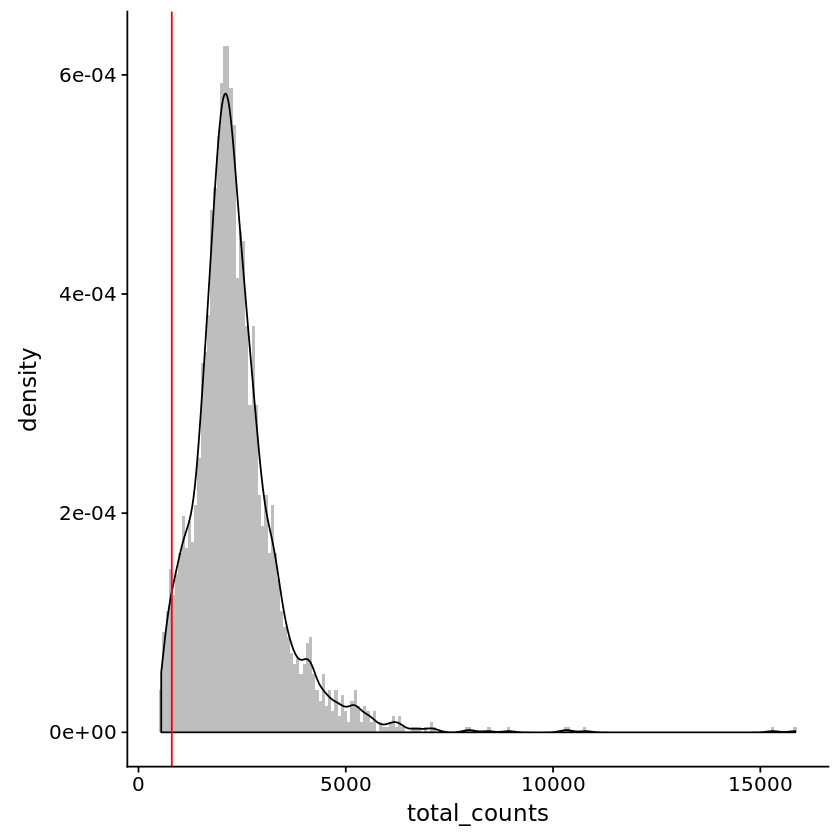

In [40]:
g1 = ggplot(as.data.frame(colData(sce))) 
g1 = g1 + geom_histogram(aes(x=total_counts, y= ..density..),bins=200,fill = "grey")
g1 = g1 + geom_density(aes(x=total_counts)) 
g1 + geom_vline(xintercept = exp(threshold), color="red")

And the filtering threshold on the log scale

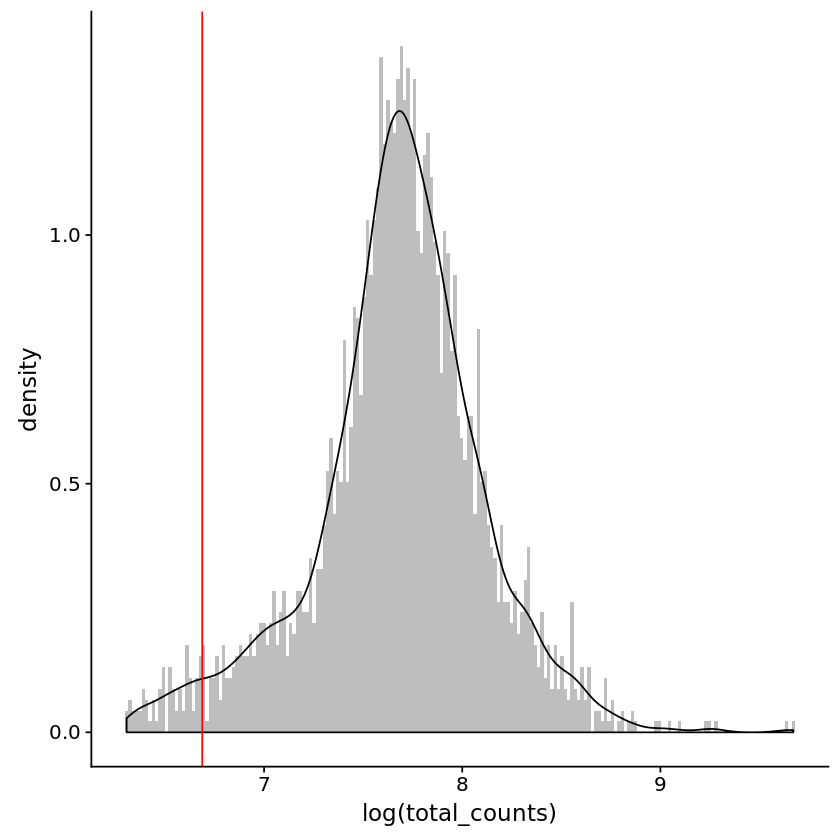

In [41]:
g1 = ggplot(as.data.frame(colData(sce))) 
g1 = g1 + geom_histogram(aes(x=log(total_counts), y= ..density..),bins=200,fill = "grey")
g1 = g1 + geom_density(aes(x=log(total_counts)))
g1 + geom_vline(xintercept = threshold, color="red")

<hr class="style0">
Lets run filtering on the total number of genes detected per cell

In [42]:
threshold = median(log(colData(sce)$total_features)) - 3*mad(log(colData(sce)$total_features))
threshold
                   
feature.keep <- !isOutlier(sce$total_features, nmads=3, type="lower", log=TRUE)
table(feature.keep)

[1] 5.99287

feature.keep
FALSE  TRUE 
   97  2603 

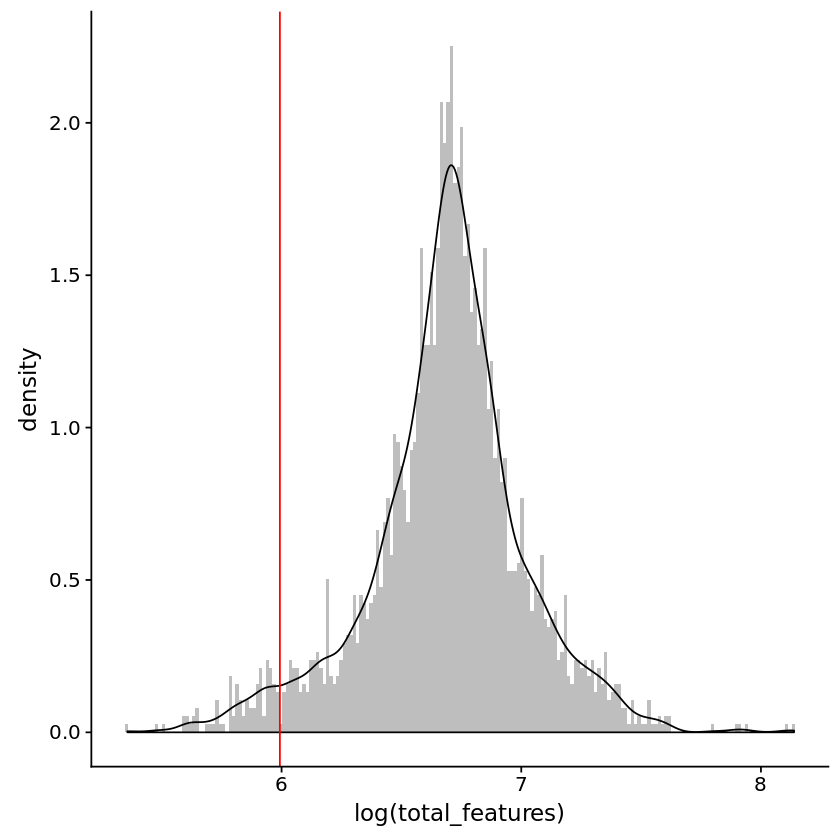

In [43]:
g1 = ggplot(as.data.frame(colData(sce))) 
g1 = g1 + geom_histogram(aes(x=log(total_features), y= ..density..),bins=200,fill = "grey")
g1 = g1 + geom_density(aes(x=log(total_features)))
g1 + geom_vline(xintercept = threshold, color="red")

<hr class="style0">


__`Scater`__ provides a way to store the filters in a vector so that we can use it at the very end to filter based on all the possible filters we generate

In [44]:
sce.filt$use <- (
    # sufficient features (genes)
    feature.keep &
    # sufficient molecules counted
    libsize.keep &
    # remove cells with unusual number of reads in MT genes
    mito.keep
)

In [45]:
table(sce.filt$use)


FALSE  TRUE 
  174  2526 

<hr class="style0">

Lets also filter to keep all genes with expression values in at least 2 cells

In [46]:
filter_genes <- apply(counts(sce.filt[ ,sce.filt$use]), 1, 
    function(x)
        {
        length(x[x > 1]) >= 2
        }
    )

rowData(sce.filt)$use <- filter_genes
table(rowData(sce.filt)$use)


FALSE  TRUE 
 9550  7084 

In [47]:
table(colData(sce.filt)$use)


FALSE  TRUE 
  174  2526 

<hr class="style0">

The __`Scater`__ package provides several plot functions that are very useful and it is highly recommneded that you explore all the possibilities. Furthermore, once you have the
Use to generate multiple kinds of expression QC plots:

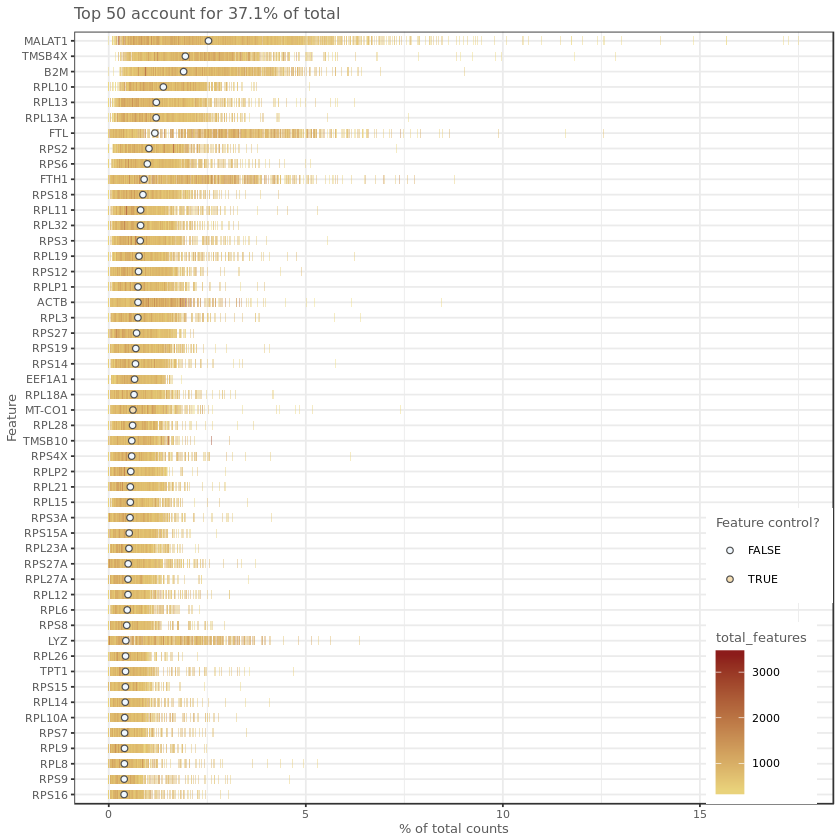

In [48]:
plotQC(sce.filt, type = "highest-expression", exprs_values = "counts")

`geom_smooth()` using method = 'loess'


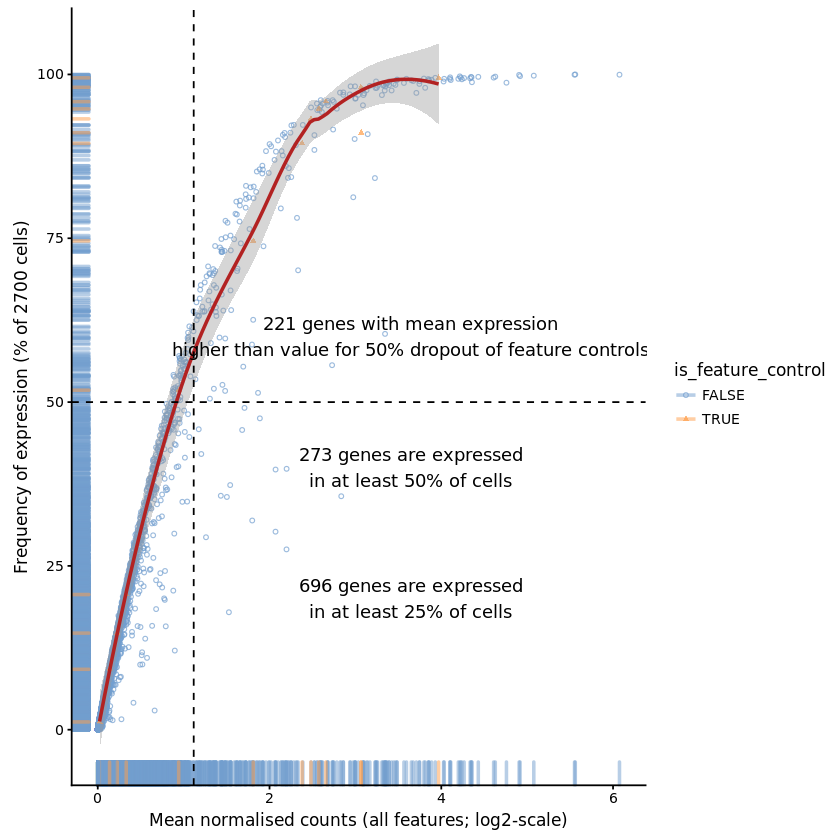

In [49]:
plotExprsFreqVsMean(sce.filt)

<hr class="style0">

We can generate MDS plots and annotate by cell atributes  to see if there are any biases

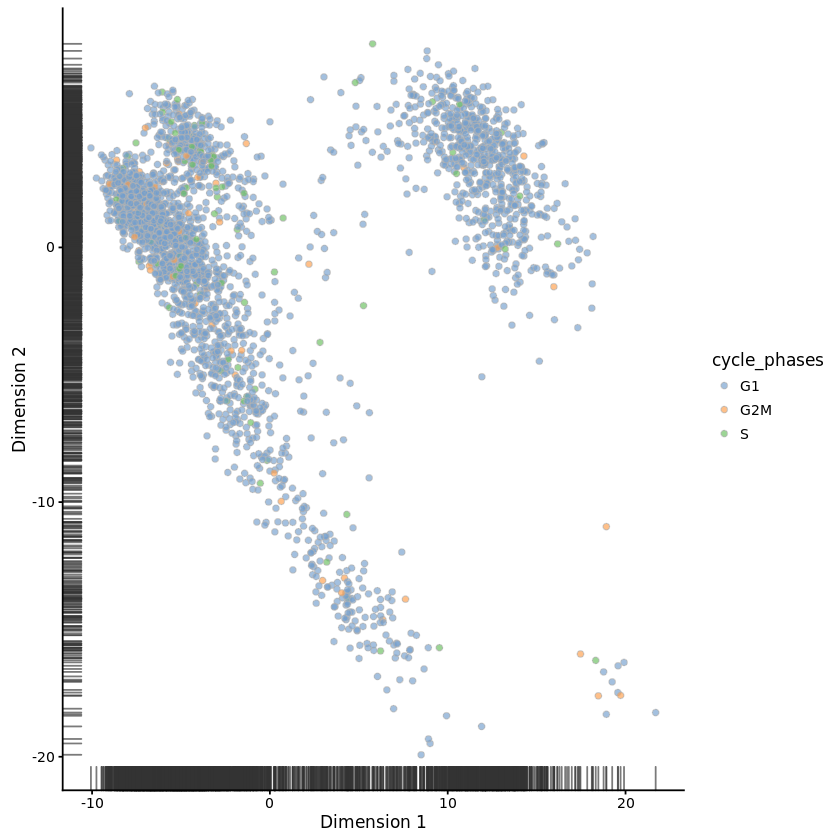

In [50]:
plotMDS(sce.filt,exprs_value="logcounts", colour_by = "cycle_phases")

<hr class="style0">

We can also generate expression plots and explore different genes

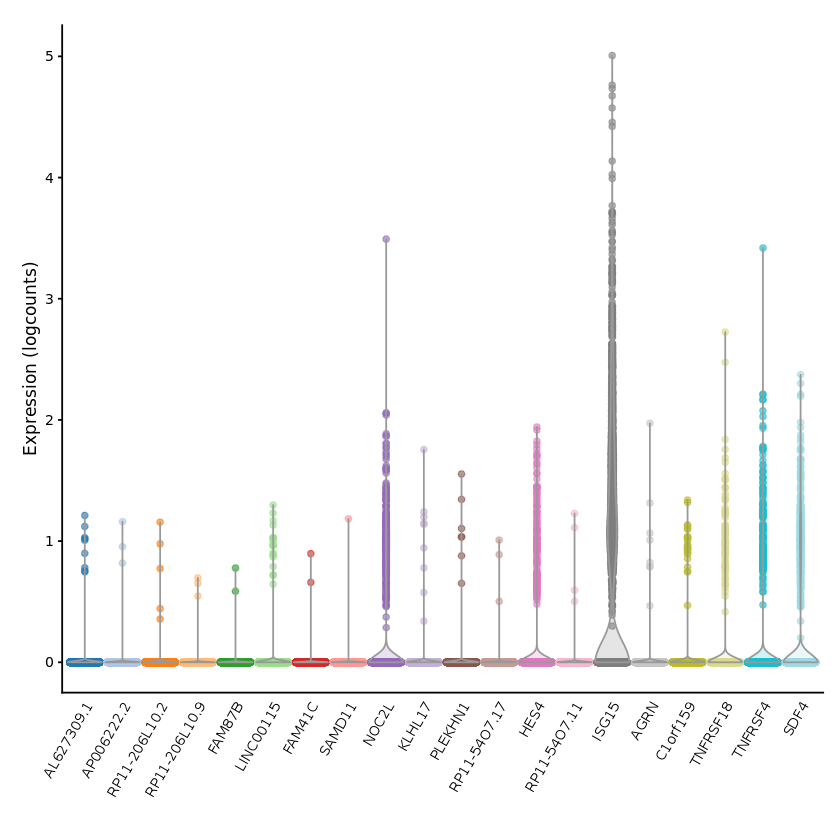

In [51]:
plotExpression(sce.filt, features=1:20)

<hr class="style0">

We can also plot scatter plots to see there any correlations with cell attributee. Lets first look at the atttributes we have avaialbale

In [52]:
colnames(colData(sce.filt))

[1] "total_features"                        
 [2] "log10_total_features"                  
 [3] "total_counts"                          
 [4] "log10_total_counts"                    
 [5] "pct_counts_top_50_features"            
 [6] "pct_counts_top_100_features"           
 [7] "pct_counts_top_200_features"           
 [8] "pct_counts_top_500_features"           
 [9] "total_features_endogenous"             
[10] "log10_total_features_endogenous"       
[11] "total_counts_endogenous"               
[12] "log10_total_counts_endogenous"         
[13] "pct_counts_endogenous"                 
[14] "pct_counts_top_50_features_endogenous" 
[15] "pct_counts_top_100_features_endogenous"
[16] "pct_counts_top_200_features_endogenous"
[17] "pct_counts_top_500_features_endogenous"
[18] "total_features_feature_control"        
[19] "log10_total_features_feature_control"  
[20] "total_counts_feature_control"          
[21] "log10_total_counts_feature_control"    
[22] "pct_counts_feature_control"            
[23] "total_features_MT"                     
[24] "log10_total_features_MT"               
[25] "total_counts_MT"                       
[26] "log10_total_counts_MT"                 
[27] "pct_counts_MT"                         
[28] "is_cell_control"                       
[29] "cycle_phases"                          
[30] "G1"                                    
[31] "S"                                     
[32] "G2M"                                   
[33] "use"

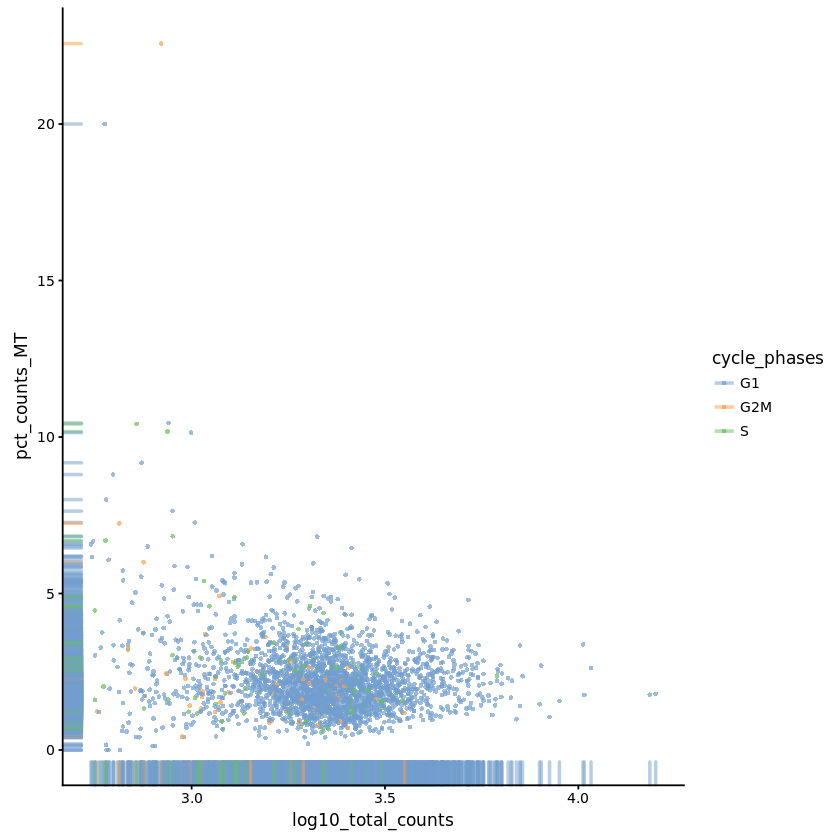

In [53]:
plotColData(sce.filt, aes(x = log10_total_counts, y = pct_counts_MT, color=cycle_phases))

<hr class="style0">
Finally we can also use plot diffusion maps a non-linear dimension reduction approach that 

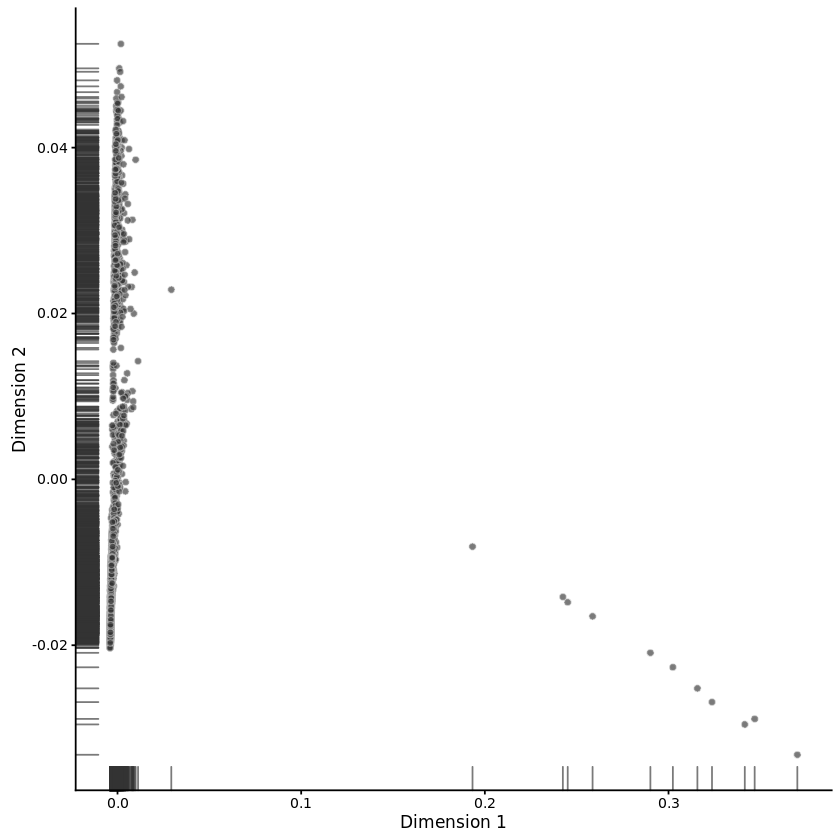

In [54]:
plotDiffusionMap(sce.filt)
#, color_by="cycle_phases")
#, aes(x = log10_total_counts, y = total_features, colour = log10_mean_counts))

We use the information above to filter out cells. Here we choose those that have percent mitochondrial genes max of 10% and unique UMI counts under 20,000 or greater than 500, Note that low.thresholds and high.thresholds are used to define a 'gate' -Inf and Inf should be used if you don't want a lower or upper threshold.

Lets save the `sce.filt` object for the next set of analysis

In [55]:
#save(sce.filt, file="~/workshop_materials/scrna_workshop_data/pbmc_3k_sce_filt.rda")